<a href="https://colab.research.google.com/github/HJJunn/distribution_forecasting/blob/main/Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [8]:
df= pd.read_csv("/content/df (1).csv")

In [9]:
df['year_week'] = pd.to_datetime(df['year'].astype(str) + df['week'].astype(str).str.zfill(2) + '0', format='%Y%U%w')

In [10]:
df1 = df.groupby('year_week')[['month', 'week','weekday','year', '명절']].first().reset_index()
df2 = df.groupby('year_week')['가공식품류'].sum().reset_index()
df = pd.merge(df1, df2, on='year_week')

In [11]:
df

,year_week,month,week,weekday,year,명절,가공식품류
0,2021-01-03,1,1,0,2021,0,5667
1,2021-01-10,1,2,0,2021,0,5421
2,2021-01-17,1,3,0,2021,0,4531
3,2021-01-24,1,4,0,2021,0,6214
4,2021-01-31,2,5,0,2021,1,8595
...,...,...,...,...,...,...,...
151,2023-11-26,11,48,0,2023,0,3278
152,2023-12-03,12,49,0,2023,0,4012
153,2023-12-10,12,50,0,2023,0,4051
154,2023-12-17,12,51,0,2023,0,4319


In [12]:
data = df.sort_values(by='year_week')
features = ['가공식품류', '명절']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[features])

# 스케일링된 데이터를 다시 데이터프레임으로 변환
data_scaled = pd.DataFrame(data_scaled, columns=features)

In [13]:
# create_sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

sequence_length = 4
x, y = create_sequences(data_scaled.values, sequence_length)

In [14]:
#데이터 셋 나누기
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
def objective(trial):
    # 하이퍼 파라미터 추천
    lstm_units_1 = trial.suggest_int("lstm_units_1", 32, 128)
    lstm_units_2 = trial.suggest_int("lstm_units_2", 16, 64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 10

    # 모델 생성하기
    model = Sequential([
        LSTM(lstm_units_1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])


    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mean_squared_error")

    # 모델 훈련
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        verbose=0
    )

    # val_loss를 통해서 모델 평가하기
    val_loss = model.evaluate(x_test, y_test, verbose=0)
    return val_loss

In [16]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

#  최적의 하이퍼파라미터 추출
print("Best trial:", study.best_trial.params)


[I 2024-12-13 21:43:42,619] A new study created in memory with name: no-name-56b3c868-9db5-4363-9b16-bb1521932b2b
<ipython-input-15-ef456d430fdd>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-12-13 21:43:48,595] Trial 0 finished with value: 0.033139608800411224 and parameters: {'lstm_units_1': 87, 'lstm_units_2': 64, 'dropout_rate': 0.29416550141735837, 'learning_rate': 0.0006027151225319659, 'batch_size': 64}. Best is trial 0 with value: 0.033139608800411224.
[I 2024

Best trial: {'lstm_units_1': 99, 'lstm_units_2': 54, 'dropout_rate': 0.49695914461148377, 'learning_rate': 0.001530271068207418, 'batch_size': 64}


In [17]:
# 최적의 하이퍼 파라미터로 훈련
best_params = study.best_trial.params
model = Sequential([
    LSTM(best_params["lstm_units_1"], return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]), loss="mean_squared_error")
model.fit(x_train, y_train, epochs=50, batch_size=best_params["batch_size"], validation_data=(x_test, y_test), verbose=1)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step - loss: 0.2503 - val_loss: 0.1397
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1961 - val_loss: 0.1033
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1527 - val_loss: 0.0661
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1073 - val_loss: 0.0353
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0547 - val_loss: 0.0291
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0413 - val_loss: 0.0555
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0706 - val_loss: 0.0535
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0536 - val_loss: 0.0369
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0410 - val_loss: 0.0263
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0364 - val_loss: 0.0236
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0329 - val_loss: 0.0240
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0381 - val_loss: 0.0239


In [18]:
# 최종 모델 평가
y_pred = model.predict(x_test)
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_extended = np.hstack((y_pred, np.zeros((y_pred.shape[0], 1))))
y_test_extended = np.hstack((y_test_reshaped, np.zeros((y_test_reshaped.shape[0], 1))))

# 역변환
y_pred_rescaled = scaler.inverse_transform(y_pred_extended)[:, 0]  # sales 컬럼만 가져오기
y_test_rescaled = scaler.inverse_transform(y_test_extended)[:, 0]  # sales 컬럼만 가져오기


mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
MAE: 1072.8321732551822
RMSE: 1243.455237476577


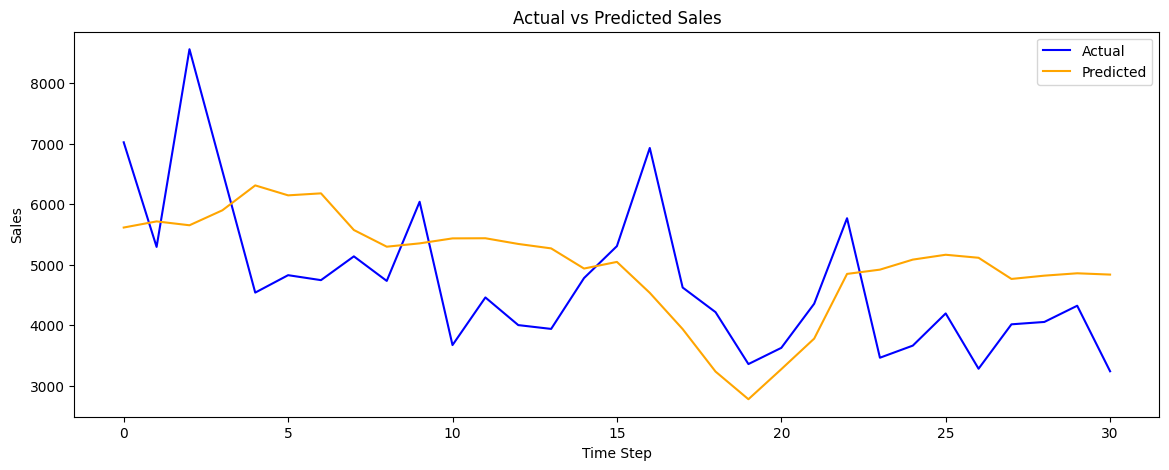

In [19]:
#  실제 그래프와 예측 그래프 비교
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', color='blue')
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted', color='orange')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.show()

# 모델 저장
model.save('lstm_sales_model.h5')

In [20]:
pip install optuna